In [26]:
# Standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display
from scipy.stats import mannwhitneyu, wilcoxon

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from lib.gallegosalas.data_fc_db_sessional import DataFCDatabase
from mesostat.metric.metric import MetricCalculator
from mesostat.utils.plotting import imshow

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
params = {}
# params['root_path_data']  = gui_fpath("Path to data collection",  './')
params['root_path_data'] = '/media/alyosha/Data/TE_data/yasirdata2/'

In [28]:
dataDB = DataFCDatabase(params)

Reading channel label file
Reading allen brain map
Reading task structure
Searching for data files


In [4]:
dataDB.read_neuro_files()
len(dataDB.dataNeuronal)

IntProgress(value=0, description='Read Neuro Data:', max=42)

42

# Multi-Regional Metrics

* Measures of instantainous redundancy
    - Average Correlation
    - PCA(1) - ?
    - Entropy, TC
* Measures of temporal relations
    - CrossCorrelation
    - CrossMI
    - PI_ND
    
## TODO
1. Normalization of entropy
    * Check if entropy outliers correlate with number of trials
    * Test NPEET metrics for convergence.
    * Check why TC is sometimes negative, it should not be
2. Improve convergence using sliding window to increase number of samples

In [5]:
# Average STD over channels, otherwise it is weird
def metricWrapper(metric, metricSettings):
    if metric == 'std':
        return np.mean(mc.metric3D(metric, 'ps', metricSettings=metricSettings, sweepSettings=None), axis=0)
    else:
        return mc.metric3D(metric, 's', metricSettings=metricSettings, sweepSettings=None)
    
def partitionMean(data, fps, window, intervDict):
    nTimeOrig = len(data) + window - 1
    times = dataDB.get_times_by_idx(nTimeOrig, window)
    assert len(times) == len(data)
    
    intervLst = list(intervDict.keys()) + [1000]  # Last step includes tail
    rez = []
    for iInterv in range(1, len(intervLst)):
        tLeft = intervLst[iInterv-1]
        tRight = intervLst[iInterv]
        timeIdxs = (times >= tLeft) & (times < tRight)
        rez += [np.mean(data[timeIdxs], axis=0)]
    return rez

Doing metric std
--doing mouse m9abs
--doing mouse m9dff


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


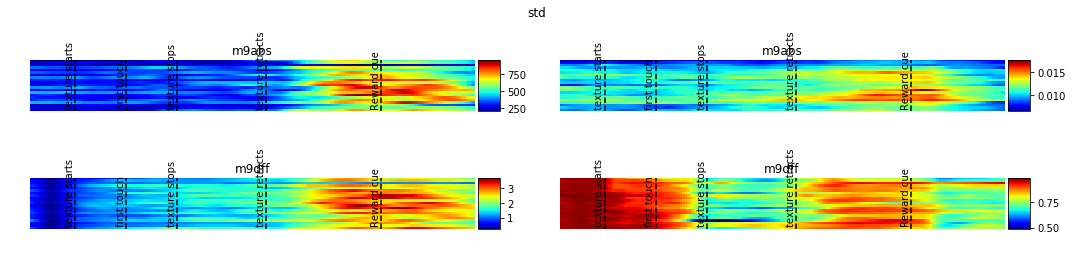

Doing metric avg_entropy_1D
--doing mouse m9abs
--doing mouse m9dff


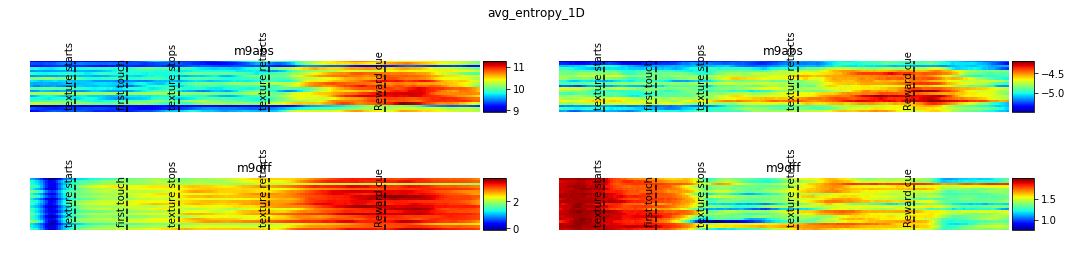

Doing metric avg_entropy
--doing mouse m9abs
--doing mouse m9dff


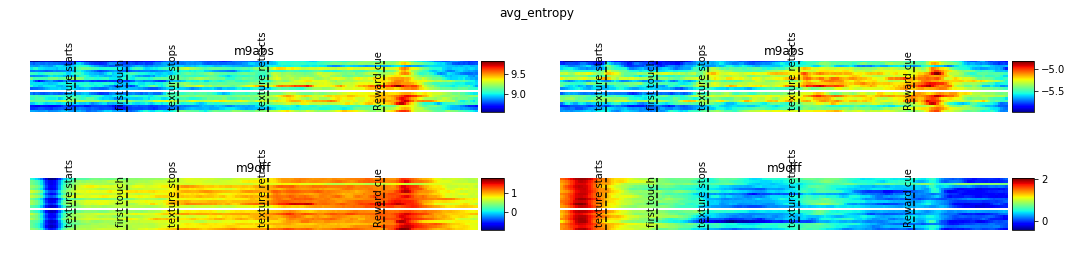

Doing metric avg_TC
--doing mouse m9abs
--doing mouse m9dff


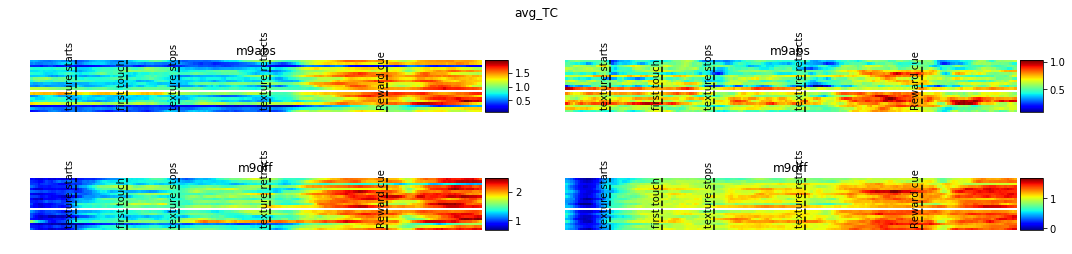

In [6]:
bigDict = {}
    
window = 6
mc = MetricCalculator(serial=False, verbose=False)

for metric in ['std', 'avg_entropy_1D', 'avg_entropy', 'avg_TC']:
    print('Doing metric', metric)
    fig, ax = plt.subplots(nrows=len(dataDB.mice), ncols=2, figsize=(15, 2 * len(dataDB.mice)), tight_layout=True)
    fig.suptitle(metric)
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print('--doing mouse', mousename)
        rows = dataDB.get_rows('neuro', {'mousename' : mousename})

        for iZS, zs in enumerate([None, 'p']):
            rez = []
            for idx, row in rows.iterrows():
                mc.set_data(dataDB.dataNeuronal[idx], 'rps', zscoreDim=zs, timeWindow=window)
                rezTmp = mc.metric3D('std', 'ps', metricSettings=None, sweepSettings=None)
                rez += [metricWrapper(metric, {'lag' : 1})]

                times = dataDB.get_times_by_idx(dataDB.dataNeuronal[idx].shape[2], window)
                extent = [np.min(times), np.max(times), 0, 1]

            imshow(fig, ax[iMouse][iZS], np.array(rez), cmap='jet', haveColorBar=True, title=mousename, extent=extent)
            dataDB.label_plot_timestamps(ax[iMouse][iZS], shX=-0.2, linecolor='k', textcolor='k')

            bigDict[(metric, mousename, zs)] = partitionMean(np.array(rez).T, 20, window, dataDB.timestamps)

    plt.savefig(metric + '_bg_sub.svg')
    plt.show()

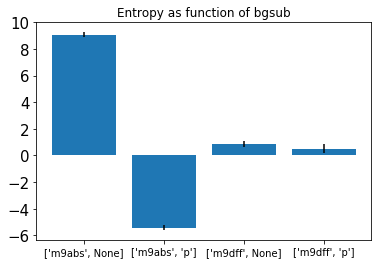

In [23]:
rezMu = []
rezStd = []
labels = []


for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    for iZS, zs in enumerate([None, 'p']):
        key = ('avg_entropy', mousename, zs)
        sessionPartitions = np.array(bigDict[key])

        mu = np.nanmean(sessionPartitions)
        std = np.nanstd(sessionPartitions)# / np.sqrt(sessionPartitions.flatten().shape[0])

        labels += [str([mousename, zs])]
        rezMu += [mu]
        rezStd += [std]

ax = plt.subplot()
ax.set_title('Entropy as function of bgsub')
ax.bar(labels, rezMu, yerr=rezStd)
for item in ax.get_yticklabels():
    item.set_fontsize(15)

plt.savefig('avg_entropy_barplot_bgsub.svg')
plt.show()

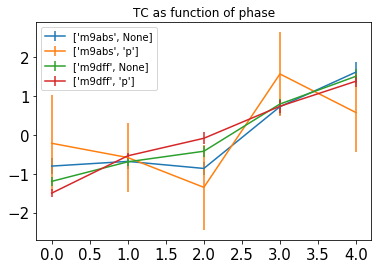

In [25]:
ax = plt.subplot()
ax.set_title('TC as function of phase')

for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    for iZS, zs in enumerate([None, 'p']):
        key = (metric, mousename, zs)
        sessionPartitions = np.array(bigDict[key])

        mu = np.nanmean(sessionPartitions, axis=1)
        std = np.nanstd(sessionPartitions, axis=1) / np.sqrt(sessionPartitions.shape[1])

        mu -= np.mean(mu)
        stdMu = np.std(mu)
        mu /= stdMu
        std /= stdMu
        
        ax.errorbar(np.arange(len(mu)), mu, std, label=str([mousename, zs]))

ax.legend()
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(15)

plt.savefig('tc_phase_plot.svg')
plt.show()

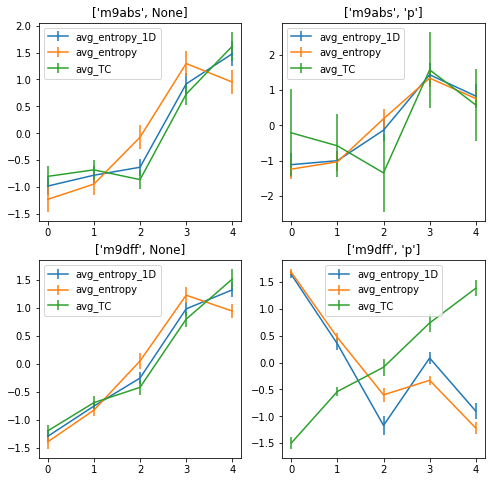

In [8]:
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    for iZS, zs in enumerate([None, 'p']):
        ax[iMouse, iZS].set_title(str([mousename, zs]))

        for metric in ['avg_entropy_1D', 'avg_entropy', 'avg_TC']:

            key = (metric, mousename, zs)
            sessionPartitions = np.array(bigDict[key])
            
            mu = np.nanmean(sessionPartitions, axis=1)
            std = np.nanstd(sessionPartitions, axis=1) / np.sqrt(sessionPartitions.shape[1])
            
            mu -= np.mean(mu)
            stdMu = np.std(mu)
            mu /= stdMu
            std /= stdMu
            
                        
            ax[iMouse, iZS].errorbar(np.arange(len(mu)), mu, std, label=metric)
        ax[iMouse, iZS].legend()
plt.show()

# Predictive Info

20180301a
20180301b
20180302b
20180302c
20180305a
20180305b
20180306a
20180306b
20180307a
20180307b
20180307c
20180308a
20180308b
20180309a
20180309b
20180313a
20180313b
20180313c
20180315a
20180316a
20180316b
20180301a
20180301b
20180302b
20180302c
20180305a
20180305b
20180306a
20180306b
20180307a
20180307b
20180307c
20180308a
20180308b
20180309a
20180309b
20180313a
20180313b
20180313c
20180315a
20180316a
20180316b
20180301a
20180301b
20180302b
20180302c
20180305a
20180305b
20180306a
20180306b
20180307a
20180307b
20180307c
20180308a
20180308b
20180309a
20180309b
20180313a
20180313b
20180313c
20180315a
20180316a
20180316b
20180301a
20180301b
20180302b
20180302c
20180305a
20180305b
20180306a
20180306b
20180307a
20180307b
20180307c
20180308a
20180308b
20180309a
20180309b
20180313a
20180313b
20180313c
20180315a
20180316a
20180316b


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


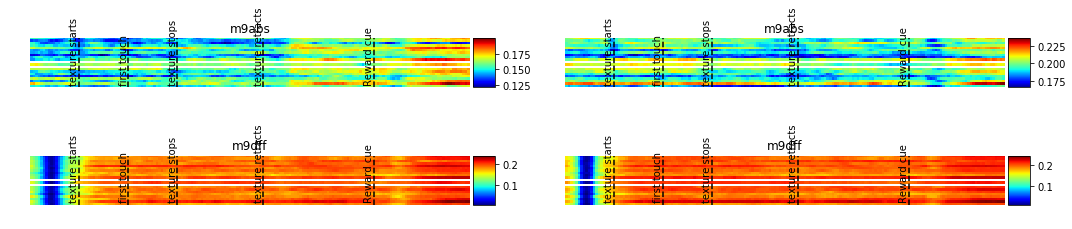

In [17]:
window = 6
mc = MetricCalculator(serial=True, verbose=False)

fig, ax = plt.subplots(nrows=len(dataDB.mice), ncols=2, figsize=(15, 2 * len(dataDB.mice)), tight_layout=True)
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    for iZS, zs in enumerate([None, 'p']):
        rez = []
        for idx, row in rows.iterrows():
            print(row['session'])
            
            mc.set_data(dataDB.dataNeuronal[idx], 'rps', zscoreDim=zs, timeWindow=window)
            rez += [mc.metric3D('avg_PI', 's', metricSettings={'max_lag' : 1}, sweepSettings=None)]
            
            times = dataDB.get_times_by_idx(idx)
            extent = [np.min(times), np.max(times), 0, 1]
        
        imshow(fig, ax[iMouse][iZS], np.array(rez), cmap='jet', haveColorBar=True, title=mousename, extent=extent)
        dataDB.label_plot_timestamps(ax[iMouse][iZS], shX=-0.2, linecolor='k', textcolor='k')

plt.savefig('avgpi_bg_sub.svg')        
plt.show()